In [43]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

projectRoot = Path().resolve().parent
dataPath = projectRoot / 'data' / 'processed' / 'features_with_composites.parquet'
df = pd.read_parquet(dataPath)
df.shape

(1000000, 90)

In [2]:
# selecting features for clustering
"""We will be utilizing composite score features for this purpose"""

composite_cols = [
    'wellbeing_score',
    'shopping_engagement_score',
    'price_awareness_score',
    'impulse_purchase_score',
    'review_influence_score',
    'shopping_funnel_score'
]

X_clustering = df[composite_cols].copy()

# scaling the feature set
scl_std = StandardScaler()
X_clustering_scaled = scl_std.fit_transform(X_clustering)

X_clustering_scaled

array([[-1.53151273, -0.06326521,  0.92152853, -1.07964426,  1.07727484,
         1.07612353],
       [ 0.82479809,  0.11978431, -1.02138766, -0.46718821,  0.47587994,
        -0.51495894],
       [ 0.23572039,  0.30283384, -1.59086309, -0.87549224, -0.36607293,
        -1.82726201],
       ...,
       [-0.35335732, -0.5666514 , -1.49036743,  0.14526784,  1.9192277 ,
        -0.78013936],
       [-0.82461948,  1.19520026, -1.18888043, -0.26303619, -0.00523598,
         0.06299837],
       [-0.5889884 ,  0.82910121,  0.85453142, -1.28379628, -0.12551497,
         0.04939937]], shape=(1000000, 6))

Iteration k = 2
Iteration k = 3
Iteration k = 4
Iteration k = 5
Iteration k = 6
Iteration k = 7


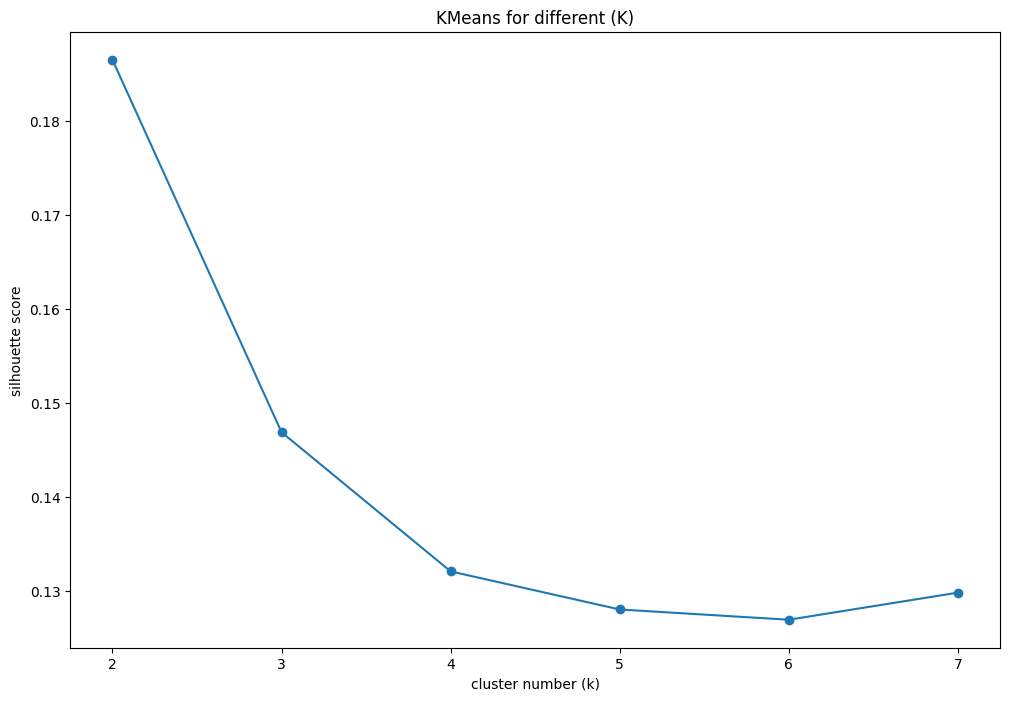

In [3]:
# determining the number of clusters based on composite scores - subsampling for k-selection
silhouette_scores = []
max_cluster_number = 8

# sample dataset for fitting KMeans
sample_idx = np.random.choice(
    X_clustering_scaled.shape[0],
    size = int(len(X_clustering_scaled) * 0.1), # sampling 20% of the feature dataset
    replace=False
)

X_clustering_scaled_sample = X_clustering_scaled[sample_idx]

for i in range(2, max_cluster_number):
    print(f'Iteration k = {i}')
    km = KMeans(
        n_clusters = i,
        n_init=10,
        random_state=7
    )
    labels = km.fit_predict(X_clustering_scaled_sample)

    silhouette_scores.append(
        silhouette_score(
            X_clustering_scaled_sample,
            labels
        )
    )
    
# plotting silhouette scores for different cluster numbers
plt.figure(figsize=(12, 8))
plt.plot(
    range(2, max_cluster_number),
    silhouette_scores,
    marker = 'o'
)
plt.title(f'KMeans for different (K)')
plt.xlabel('cluster number (k)')
plt.ylabel('silhouette score')
plt.show()

Considering the silhouette scores, it is smart to choose k=3, and clustering the data by:

- Low intensity shoppers
- Medium intensity shoppers
- High intensity shoppers

In [4]:
# fitting KMeans for a selected K on full dataset
max_cluster_number = 8
k = 3

km = KMeans(
    n_clusters = k,
    n_init=5,
    random_state=7
)
labels = km.fit_predict(X_clustering_scaled)

silhouette_score_bestK = silhouette_score(
    X_clustering_scaled,
    labels
)

df['cluster'] = labels

# cluster size
print('-- Cluster Size --')
print(df['cluster'].value_counts(normalize=True).sort_index())

# cluster profile
cluster_profile = df.groupby('cluster')[composite_cols].mean().round(4)
cluster_profile

-- Cluster Size --
cluster
0    0.293666
1    0.292004
2    0.414330
Name: proportion, dtype: float64


,wellbeing_score,shopping_engagement_score,price_awareness_score,impulse_purchase_score,review_influence_score,shopping_funnel_score
cluster,,,,,,
0,-0.5908,0.0008,-0.9073,-0.6504,-0.0033,-0.1992
1,-0.6054,-0.0019,0.8982,-0.6651,0.0036,-0.1935
2,0.8454,0.0008,0.0100,0.9297,-0.0002,0.2776


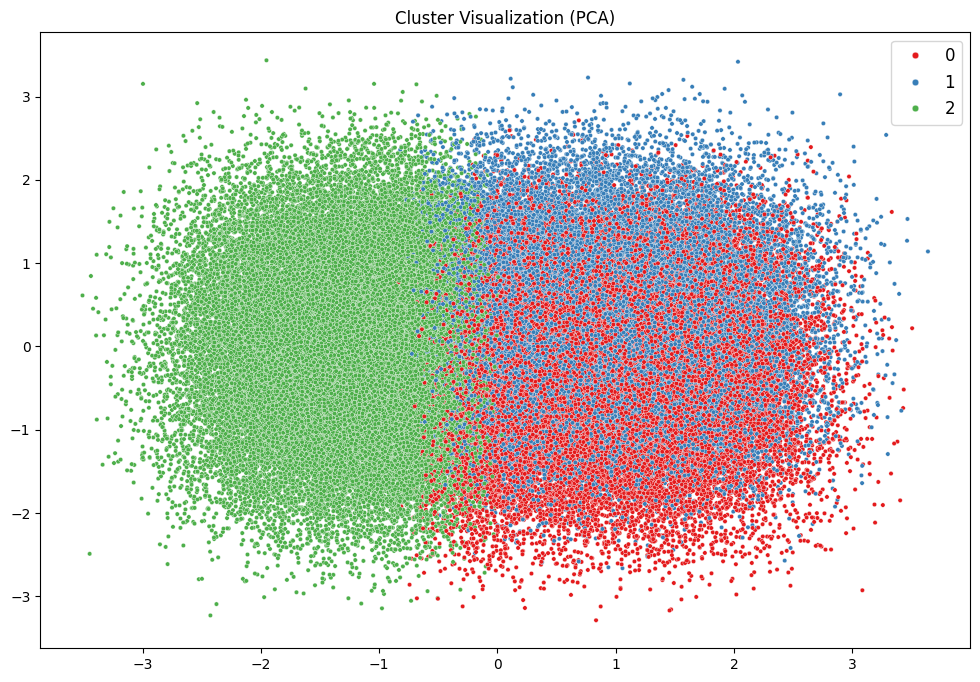

In [5]:
# Visualizing customer segmentation by using PCA
pca = PCA(
    n_components=2,
    random_state=7
)

X_pca = pca.fit_transform(X_clustering_scaled_sample)
km_sample = KMeans(
    n_clusters=k,
    n_init=10,
    random_state=7
)
labels_sample = km_sample.fit_predict(X_clustering_scaled_sample)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=labels_sample,
    s=10,
    legend='full',
    palette='Set1'
)
plt.title('Cluster Visualization (PCA)')
plt.legend(
    fontsize=12,
    markerscale=1.5
)
plt.show()

In [13]:
# cluster interpretation
def qualitative_labeling(value, very_high=0.5, high = 0.15, low = -0.15, very_low=-0.5):
    if value > very_high:
        return 'Very High'
    elif value > high:
        return 'High'
    elif value < very_low:
        return 'Very Low'
    elif value < low:
        return 'Low'
    else:
        return 'Avg'

cluster_profile_qualitative = cluster_profile.map(qualitative_labeling)
cluster_profile_qualitative

,wellbeing_score,shopping_engagement_score,price_awareness_score,impulse_purchase_score,review_influence_score,shopping_funnel_score
cluster,,,,,,
0,Very Low,Avg,Very Low,Very Low,Avg,Low
1,Very Low,Avg,Very High,Very Low,Avg,Low
2,Very High,Avg,Avg,Very High,Avg,High


Cluster profile table shows that 'shopping_engagement_score' and 'review_influence_score' composite features are not a differentiator for customer segmentation. 

Main drivers are:
- Wellbeing
- Price Awareness
- Impulse Purchase
- Shopping Funnel


In [ ]:
# dropping respective composite features that are not a key differentiator for clusters
cluster_profile_qualitative = cluster_profile_qualitative.drop(
    columns=[
        'shopping_engagement_score', 
        'review_influence_score'
    ]
)
cluster_profile_qualitative

,wellbeing_score,price_awareness_score,impulse_purchase_score,shopping_funnel_score
cluster,,,,
0,Very Low,Very Low,Very Low,Low
1,Very Low,Very High,Very Low,Low
2,Very High,Avg,Very High,High


In [42]:
# cluster summary
def summarize_clusters(row):
    very_high = row[row == 'Very High'].index.tolist()
    high = row[row == 'High'].index.tolist()
    avg = row[row == 'Avg'].index.tolist()
    low = row[row == 'Low'].index.tolist()
    very_low = row[row == 'Very Low'].index.tolist()

    summary = []
    if very_high:
        summary.append(f"Very High in {', '.join(very_high)}")
    if high:
        summary.append(f"High in {', '.join(high)}")
    if avg:
        summary.append(f"Avg in {', '.join(avg)}")
    if low:
        summary.append(f"Low in {', '.join(low)}")
    if very_low:
        summary.append(f"Very Low in {', '.join(very_low)}")
    
    return ' | '.join(summary)

cluster_summary = cluster_profile_qualitative.apply(
    summarize_clusters, 
    axis=1
)

cluster_names = {
    0: 'Low-Intent Browsers',
    1: 'Price-Sensitive Researchers',
    2: 'High-Value Impulse Buyers'
}

cluster_interpretation = pd.DataFrame({
    'archetype': pd.Series(cluster_names),
    'summary': cluster_summary
})

for i, row in cluster_interpretation.iterrows():
    print(f'Cluster {i}: {row.archetype} -> {row.summary}')

Cluster 0: Low-Intent Browsers -> Low in shopping_funnel_score | Very Low in wellbeing_score, price_awareness_score, impulse_purchase_score
Cluster 1: Price-Sensitive Researchers -> Very High in price_awareness_score | Low in shopping_funnel_score | Very Low in wellbeing_score, impulse_purchase_score
Cluster 2: High-Value Impulse Buyers -> Very High in wellbeing_score, impulse_purchase_score | High in shopping_funnel_score | Avg in price_awareness_score


In [60]:
# cluster stability validation
def kmeans_subsample_labels(
    X,
    n_clusters,
    sample_ratio=0.1,
    random_state=None
):
    rng = np.random.default_rng(random_state)
    idx = rng.choice(
        X.shape[0],
        size=int(X.shape[0] * sample_ratio),
        replace=False
    )
    X_sample = X[idx]

    km = KMeans(
        n_clusters=n_clusters,
        n_init=5,
        random_state=random_state
    )
    labels = km.fit_predict(X_sample)

    return idx, labels

n_runs = 5
ari_scores = {}

base_idx, base_labels = kmeans_subsample_labels(
    X_clustering_scaled,
    n_clusters=k,
    random_state=7
)

for seed in range(1, n_runs+1):

    idx, labels = kmeans_subsample_labels(
        X_clustering_scaled,
        n_clusters=k,
        random_state=7+seed
    )

    # comparing overlapping subsamples
    common = np.intersect1d(base_idx, idx)

    base_common = base_labels[np.isin(base_idx, common)]
    labels_common = labels[np.isin(idx, common)]

    ari = adjusted_rand_score(base_common, labels_common)
    ari_scores[f'Iteratiın {seed}'] = round(ari, 4)

ari_scores


{'Iteratiın 1': 0.0005,
 'Iteratiın 2': -0.0002,
 'Iteratiın 3': -0.0002,
 'Iteratiın 4': -0.0001,
 'Iteratiın 5': 0.0001}

Since ARI score is less than 0.4, we conclude that behavioral data is noisy; therefore the cluster stabilities are unstable per different runs.  